In [7]:
import pandas as pd
import numpy as np
import os

In [8]:
# smape: symmetric mean absolute percentage error
# mape: mean absolute percentage error
# mase: mean absolute scaled error
# owa: overall weighted average

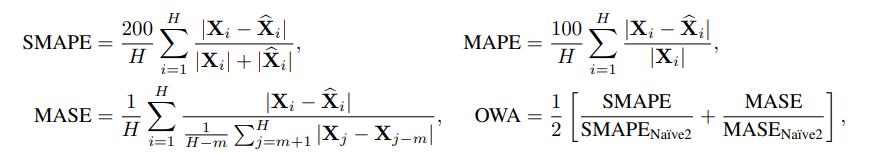

In [9]:
freqs = ['Hourly', 'Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly']
path = '/data/coding/chaochuan/TSGym/test_resultsGym'
model_list = os.listdir(path)
model_list = list(set([_.replace('_fit_time_per_epoch', '').replace('.npz', '') for _ in model_list if _.endswith('.npz') ]))
model_list = [m for m in model_list if all(k not in m for k in freqs)]
print(model_list)

['m4_TSGym_RevIN_True_positional-encoding_Transformer_frequency-enhanced-attention_True', 'm4_TSGym_Stat_False_positional-encoding_MLP_null_True', 'm4_TSGym_RevIN_False_positional-encoding_GRU_null_True', 'm4_TSGym_RevIN_True_positional-encoding_Transformer_auto-correlation_True', 'm4_TSGym_RevIN_True_positional-encoding_Transformer_sparse-attention_True', 'm4_TSGym_RevIN_False_positional-encoding_Transformer_self-attention_True', 'm4_TSGym_None_True_positional-encoding_Transformer_auto-correlation_True', 'm4_TSGym_None_True_positional-encoding_Transformer_sparse-attention_True', 'm4_TSGym_Stat_True_positional-encoding_Transformer_sparse-attention_True', 'm4_TSGym_None_True_positional-encoding_Transformer_self-attention_True', 'm4_TSGym_RevIN_True_positional-encoding_GRU_null_True', 'm4_TSGym_RevIN_False_positional-encoding_MLP_null_True', 'm4_TSGym_None_False_positional-encoding_Transformer_auto-correlation_True', 'm4_TSGym_RevIN_False_positional-encoding_Transformer_frequency-enhance

In [10]:
metric = 'owa'
result_dict, time_dict = {}, {}
for model in model_list:
    time_dict[model] = {}
    try:
        result = np.load(f'{path}/{model}.npz', allow_pickle=True)
        for freq in freqs:
            fit_time_per_epoch = np.load(f"{path}/{model.replace('m4', f'm4_{freq}')}_fit_time_per_epoch.npz", allow_pickle=True)
            time_dict[model][freq] = fit_time_per_epoch['time'].item()
    except Exception as error:
        print(f'error while fitting model: {model}')
        pass
        continue
    
    result_dict[model] = result[metric].item()

In [11]:
df_result = pd.DataFrame.from_dict(result_dict, orient='index')
df_time = pd.DataFrame.from_dict(time_dict, orient='index')
df_time.columns = [f'time_{_}' for _ in df_time.columns]

df_result = pd.concat([df_result, df_time], axis=1)

In [12]:
print(df_result.sort_values(by='Average').to_markdown())

|                                                                                        |   Yearly |   Quarterly |   Monthly |   Others |   Average |   time_Hourly |   time_Daily |   time_Weekly |   time_Monthly |   time_Quarterly |   time_Yearly |
|:---------------------------------------------------------------------------------------|---------:|------------:|----------:|---------:|----------:|--------------:|-------------:|--------------:|---------------:|-----------------:|--------------:|
| m4_TSGym_Stat_False_positional-encoding_Transformer_auto-correlation_True              |    0.809 |       0.89  |     0.902 |    1.057 |     0.869 |       9.00144 |      72.7216 |       8.36369 |       2499.04  |          463.646 |       587.087 |
| m4_TSGym_RevIN_False_positional-encoding_Transformer_auto-correlation_True             |    0.825 |       0.891 |     0.898 |    1.075 |     0.875 |      12.8589  |      98.3221 |      10.333   |        835.854 |          352.122 |       287.467 |
